# Multimodal training on Vertex AI


This sample shows how to run [this multimodal entailment tutorial]( https://keras.io/examples/nlp/multimodal_entailment/) as a custom training job on Vertex AI.

The TensorFlow model you'll train in this sample takes in both text and image data. 

The prediction task is:
Given the pairs of (text_1, image_1) and (text_2, image_2) do they entail (or not entail or contradict) each other?

The purpose of this notebook is to demonstrate multimodal training on Vertex AI. For more detail on the task and dataset, [check out the original tutorial.](https://keras.io/examples/nlp/multimodal_entailment/)

## Initialize SDK

Note that if you are running this notebook in Vertex AI Workbench, your environment is already authenticated. If you are running from Colab, you'll need to authenticate your GCP account in order to run a training job on Vertex AI.

In [ ]:
from google.cloud import aiplatform

In [ ]:
# Add in your project_id, region, and bucket

PROJECT_ID='{PROJECT_ID}'
REGION='{REGION}'
BUCKET_NAME='gs://{BUCKET}'

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [ ]:
# Create directory for training application code

! mkdir multimodal_sample

In [ ]:
# Create trainer

! mkdir multimodal_sample/trainer

## Visualize Data

Before we run a training job, let's visualize the data.

In [ ]:
from tensorflow import keras
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_base_path = keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

344273442/344273442 [==============================] - 10s 0us/step


In [ ]:
df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)
df.sample(5)

,id_1,text_1,image_1,id_2,text_2,image_2,label
754,1380539052215123970,@tradingview Break and retest $USD $CHF Join...,http://pbs.twimg.com/media/Eyio8qSWEAU4Wh9.jpg,1381580880884477953,@tradingview Moving lower as expected $USD $...,http://pbs.twimg.com/media/EyxcfWLW8AEDWHo.jpg,NoEntailment
387,1374033219813658631,WV WOOZI COMMENT 🌟\n@pledis_17 #SEVENTEEN #WOO...,http://pbs.twimg.com/media/ExGL7nAVEAQInW_.jpg,1374196539183169539,210323 *#WOOZI comment on #HOSHI’s post*\n\nWZ...,http://pbs.twimg.com/media/ExIgeCjUYAQJTaB.jpg,Implies
1018,1358724544131788801,I just earned the [The Forgotten One] Achievem...,http://pbs.twimg.com/media/EtsoxeTUUAE2wNx.jpg,1366747973783330817,I just earned the [The Forgotten One] Achievem...,http://pbs.twimg.com/media/EveqCi8XEAMQwSM.jpg,NoEntailment
13,1359049457367724034,#COVID19 Vaccination Tracker\n(upto 09th Febru...,http://pbs.twimg.com/media/EtxQR5aXMAQ0cxa.png,1381525016257437701,#COVID19 Vaccination Tracker\n#LargestVaccineD...,http://pbs.twimg.com/media/EywprmqWgAQzKi9.png,Contradictory
1398,1347182178619305985,@HaasF1Team This is amazing!\nAlmost as amazin...,http://pbs.twimg.com/media/ErInDTqXUAQTWbr.jpg,1382681029564059651,@HaasF1Team @nikita_mazepin Even in the simula...,http://pbs.twimg.com/media/EzBFETmXMAMMZXx.jpg,NoEntailment


In [ ]:
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}

images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1]
    extentsion_two = current_row["image_2"].split(".")[-1]

    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

# Create another column containing the integer ids of
# the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])

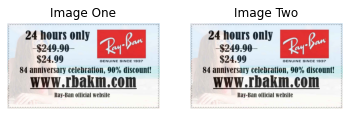

Text one: My friends!go and have a look if you are interested.
@CarrascoRosanna @AmieeEckerson @katnissvampire @Kathlee74027718 @goll7670 @MellamphyCorp https://t.co/cZJGn68rNk

Text two: Friends! Anyone interested? Go and have a look.
@Phylter52 @woody2516 @stevemchugh39 @KrizoAngela @SafetyMentalst @LeeEngleman1 @f_taggart @Buddbayman @SandraMalluck @SBellSouth1 https://t.co/CZVURWgseM

Label: Implies



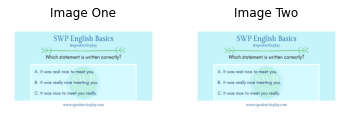

Text one: SWP #English Basics:

Which statement is written correctly?

#SWPinEnglish #toefl #grammar #ielts #vocabulary #step https://t.co/CDeZGamfOv

Text two: SWP #English Basics:

Which is the correct statement?

#SWPinEnglish #toefl #quiz #ielts #vocabulary #step #grammar #thursdaymorning https://t.co/TmgnlAmtBH

Label: NoEntailment


In [ ]:
def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print()
    print(f"Text two: {text_2}")
    print()
    print(f"Label: {label}")


random_idx = np.random.choice(len(df))
visualize(random_idx)
print()
random_idx = np.random.choice(len(df))
visualize(random_idx)

## Understand the model architecture

The model you will train in this example takes in the two images along with their text counterparts. 

The images will be directly fed to the model. The text inputs will be preprocessed and then fed to the model.
 
The model consists of:

* A standalone encoder for the images. This sample uses a
[ResNet50V2](https://arxiv.org/abs/1603.05027) pre-trained on the ImageNet-1k dataset.

* A standalone encoder for the text. A pre-trained BERT model will be used for this.

After extracting the individual embeddings, they will be projected in an identical space. Then, their projections will be concatenated and be fed to the final classification layer.

## Write Dockerfile

Now that we've looked at the image and text data we want to get predictions for, it's time to containerize our application.

In [ ]:
%%writefile multimodal_sample/Dockerfile

FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-5:latest

WORKDIR /

# Installs tensorflow text library
RUN pip install tensorflow-text==2.5.0

# Copies the trainer code to the docker image.
COPY trainer /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.task"]

Overwriting multimodal_sample/Dockerfile


## Write training code

In [ ]:
%%writefile multimodal_sample/trainer/task.py

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

"""## Define a label map"""

label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}

"""## Collect the dataset

The original dataset is available
[here](https://github.com/google-research-datasets/recognizing-multimodal-entailment).
It comes with URLs of images which are hosted on Twitter's photo storage system called
the
[Photo Blob Storage (PBS for short)](https://blog.twitter.com/engineering/en_us/a/2012/blobstore-twitter-s-in-house-photo-storage-system).
We will be working with the downloaded images along with additional data that comes with
the original dataset. Thanks to
[Nilabhra Roy Chowdhury](https://de.linkedin.com/in/nilabhraroychowdhury) who worked on
preparing the image data.
"""

image_base_path = keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

"""## Read the dataset and apply basic preprocessing"""

df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)

images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1]
    extentsion_two = current_row["image_2"].split(".")[-1]

    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

# Create another column containing the integer ids of
# the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])


df["label"].value_counts()

"""To account for that we will go for a stratified split."""

# 10% for test
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["label"].values, random_state=42
)
# 5% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["label"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

"""## Data input pipeline

TensorFlow Hub provides
[variety of BERT family of models](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub).
Each of those models comes with a
corresponding preprocessing layer. You can learn more about these models and their
preprocessing layers from
[this resource](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub).

To keep the runtime of this example relatively short, we will use a smaller variant of
the original BERT model.
"""

# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

"""Our text preprocessing code mostly comes from
[this tutorial](https://www.tensorflow.org/text/tutorials/bert_glue).
You are highly encouraged to check out the tutorial to learn more about the input
preprocessing.
"""

def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocessing_model(["text_1", "text_2"])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

"""### Run the preprocessor on a sample input"""

idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1]), np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

"""We will now create `tf.data.Dataset` objects from the dataframes.

Note that the text inputs will be preprocessed as a part of the data input pipeline. But
the preprocessing modules can also be a part of their corresponding BERT models. This
helps reduce the training/serving skew and lets our models operate with raw text inputs.
Follow [this tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)
to learn more about how to incorporate the preprocessing modules directly inside the
models.
"""

def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

"""### Preprocessing utilities"""

resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["image_1_path"])
    image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

"""### Create the final datasets"""

batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

"""## Model building utilities

Our final model will accept two images along with their text counterparts. While the
images will be directly fed to the model the text inputs will first be preprocessed and
then will make it into the model. 
The model consists of the following elements:

* A standalone encoder for the images. We will use a
[ResNet50V2](https://arxiv.org/abs/1603.05027) pre-trained on the ImageNet-1k dataset for
this.
* A standalone encoder for the images. A pre-trained BERT will be used for this.

After extracting the individual embeddings, they will be projected in an identical space.
Finally, their projections will be concatenated and be fed to the final classification
layer.

This is a multi-class classification problem involving the following classes:

* NoEntailment
* Implies
* Contradictory

`project_embeddings()`, `create_vision_encoder()`, and `create_text_encoder()` utilities
are referred from [this example](https://keras.io/examples/nlp/nl_image_search/).

Projection utilities
"""

def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

"""Vision encoder utilities"""

def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

"""Text encoder utilities"""

def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

"""Multimodal model utilities"""

def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

"""You can inspect the structure of the individual encoders as well by setting the
`expand_nested` argument of `plot_model()` to `True`. You are encouraged
to play with the different hyperparameters involved in building this model and
observe how the final performance is affected.

## Compile and train the model
"""

multimodal_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=5)

Overwriting multimodal_sample/trainer/task.py


## Containerize training application code

To run a custom training job on Vertex AI you need a container. In this case you will build and push your own container to Artifact Registry.

In [ ]:
# Create artifact registry repo

REPO_NAME='multimodal-app'

!gcloud artifacts repositories create {REPO_NAME} --repository-format=docker \
--location=us-central1 --description="Docker repository"

In [ ]:
cd multimodal_sample

In [ ]:
IMAGE_URI=f'us-central1-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME}/multimodal_image:latest'

In [ ]:
# build image

!docker build ./ -t {IMAGE_URI}

In [ ]:
# push image

! docker push {IMAGE_URI}

## Run training job

Use the Vertex AI SDK to create and run a custom training job.

In [ ]:
# Define job

my_job = aiplatform.CustomContainerTrainingJob(display_name='multimodal-job',
                                               container_uri=IMAGE_URI,
                                               staging_bucket=BUCKET_NAME)

In [ ]:
# Run job

my_job.run(replica_count=1,
           machine_type='n1-standard-8')